<a href="https://colab.research.google.com/github/JakeOh/202011_itw_bd21/blob/main/lab_ml/ml14_mnist_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# MNIST Data

In [2]:
X, y = fetch_openml(name='mnist_784', return_X_y=True)

In [3]:
X.shape  # (n_samples, n_features)

(70000, 784)

In [4]:
y.shape  # (n_samples,)

(70000,)

In [9]:
y = y.astype(np.int8)  # str 타입을 int 타입으로 변환
y.dtype

dtype('int8')

In [12]:
X.dtype

dtype('float64')

In [13]:
np.min(X[0])

0.0

In [14]:
np.max(X[0])

255.0

In [15]:
X_scaled = X / 255.0  # 데이터의 값의 범위를 0 ~ 255에서  0 ~ 1 범위로 스케일링

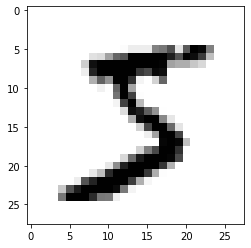

In [16]:
plt.imshow(X_scaled[0].reshape((28, 28)), cmap=plt.cm.binary)
plt.show()

## Train/Test split

In [17]:
num_train = 60_000

In [18]:
X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

In [19]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

# PCA(Principal Component Analysis)

## MNIST 데이터의 차원을 2차원으로 축소 후 시각화

In [23]:
pca = PCA(n_components=2)  # PCA 객체 생성

In [24]:
X_train_reduced = pca.fit_transform(X_train)
# fit: 주성분 찾음.
# transform: 주성분 방향으로 투영(projection) -> 차원 축소

In [25]:
X_train_reduced.shape  # (60_000, 2): 샘플 개수, 축소된 차원수

(60000, 2)